In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
# import hdbscan
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
import matplotlib.gridspec as gridspec
from sklearn.cluster import HDBSCAN
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 15})

        Unnamed: 0 site                 time          n0        D0         Nt  \
0              118  MQT  2017-10-28 09:50:00   13.079713  1.008848   424.1180   
1              119  MQT  2017-10-28 09:55:00   14.120166  1.187553   455.4020   
2              141  MQT  2017-10-28 11:45:00  138.960633  1.589766  3407.7910   
3              143  MQT  2017-10-28 11:55:00  103.511059  2.117471  3376.0270   
4              144  MQT  2017-10-28 12:00:00  283.276481  3.203841  9145.6481   
...            ...  ...                  ...         ...       ...        ...   
371138     2662648  NSA  2019-10-24 12:25:00   14.421947  1.225121   556.6407   
371139     2662649  NSA  2019-10-24 12:30:00   21.854781  3.443884   909.1400   
371140     2662651  NSA  2019-10-24 12:40:00   17.238209  3.321067   813.1602   
371141     2662652  NSA  2019-10-24 12:45:00   11.010787  1.857676   513.0960   
371142     2662784  NSA  2019-10-24 23:45:00   32.727819  1.941424  1169.4950   

              Fs       Sr  

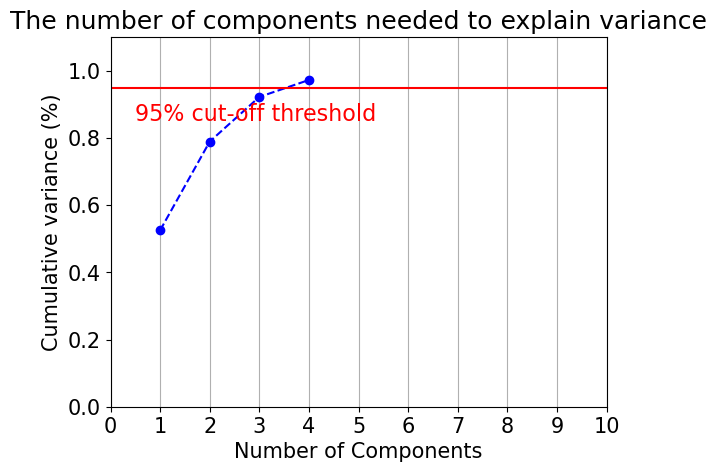

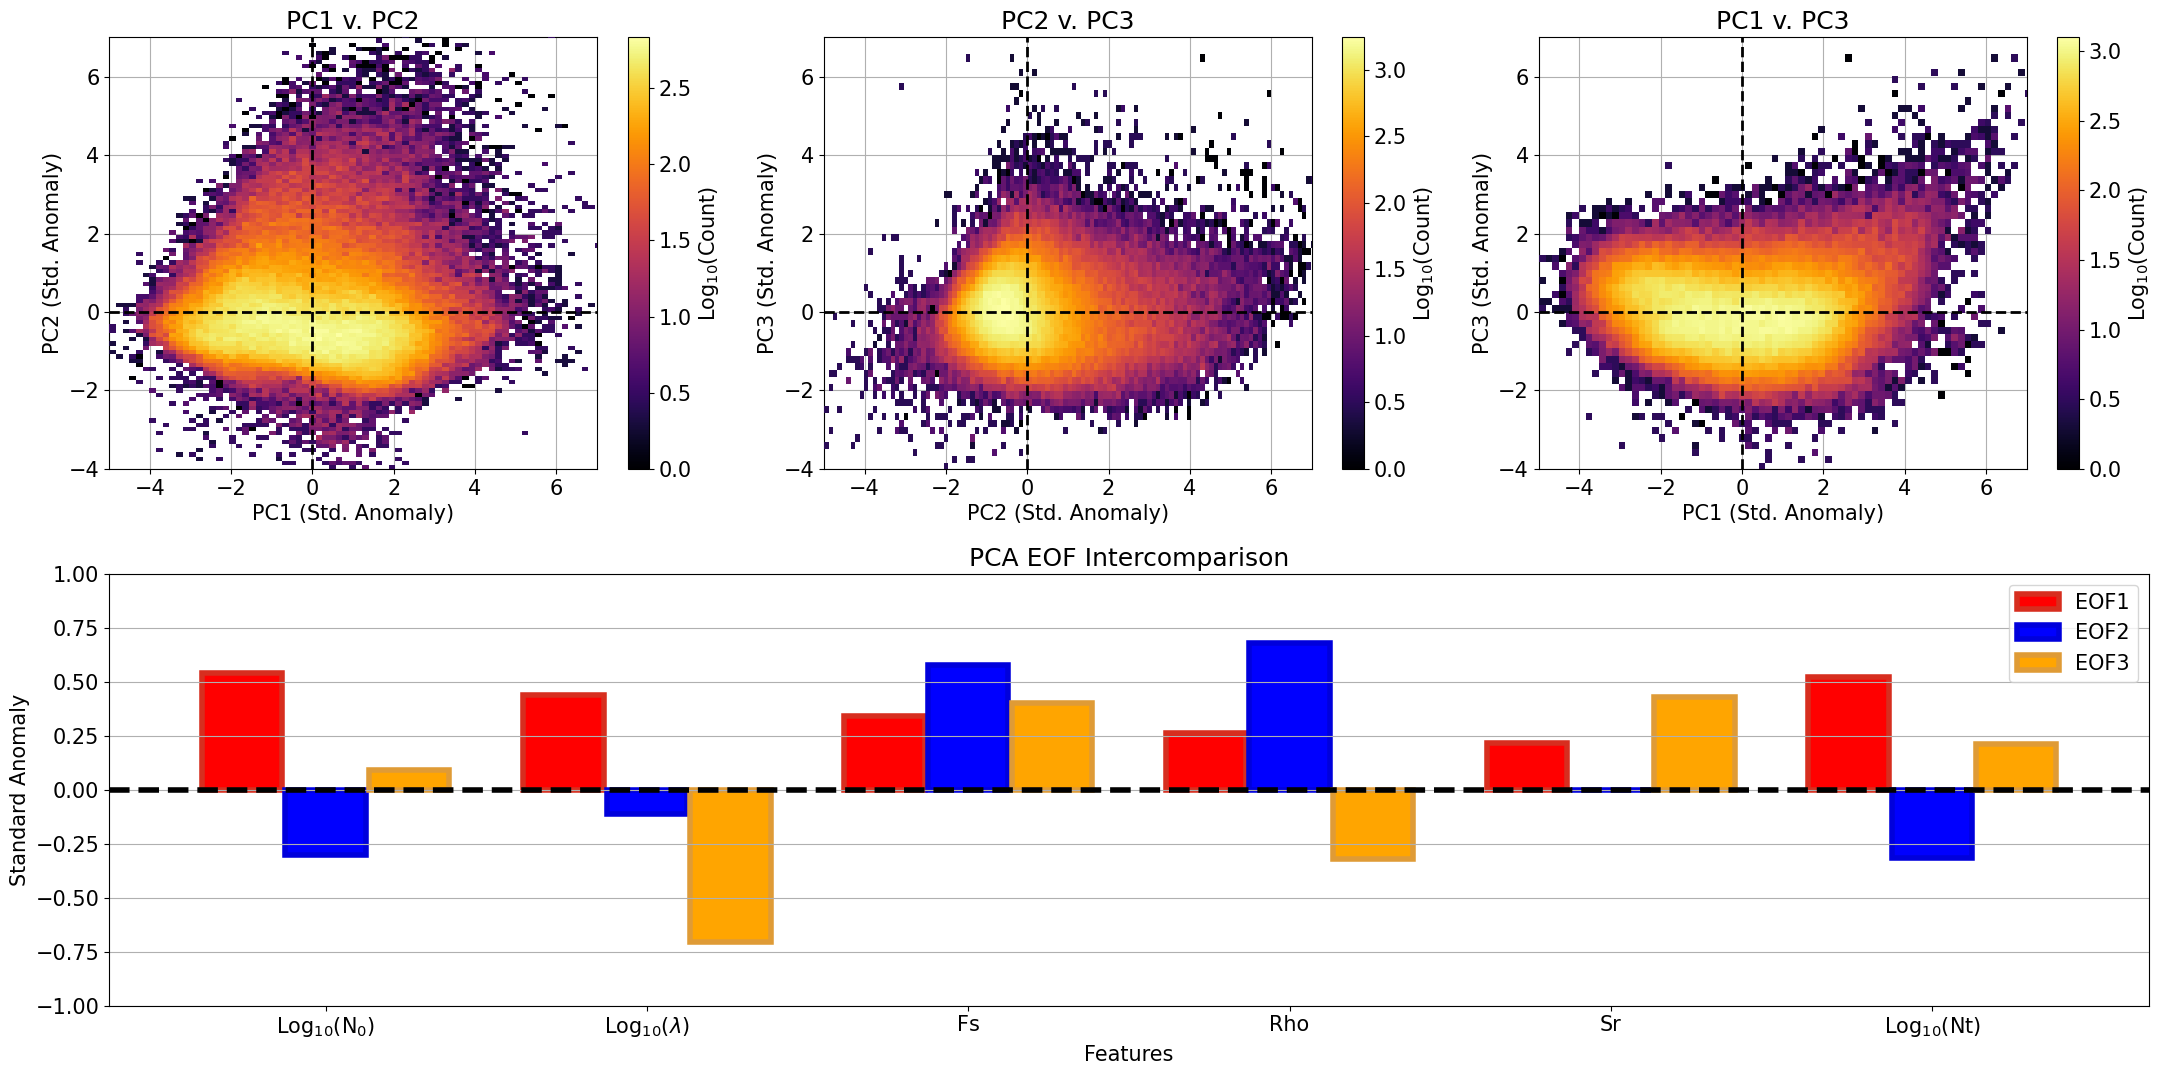

Index(['Unnamed: 0', 'site', 'time', 'n0', 'D0', 'Nt', 'Fs', 'Sr', 'Ed', 'Rho',
       'lambda', 'n0_log', 'lambda_log', 'Nt_log', 'n0_log_norm',
       'lambda_log_norm', 'Fs_norm', 'Rho_norm', 'Sr_norm', 'Nt_log_norm',
       'eof1', 'eof2', 'eof3', 'eof4'],
      dtype='object')


In [2]:

path = '/Users/fraserking/Development/pip_processing/data/processed/pca_inputs/all_sites_pip.csv'

def show_pca(df, title, colmap):
    features = ['n0_log', 'lambda_log', 'Fs', 'Rho', 'Sr', 'Nt_log']

    df_snow = df

    df_snow['n0_log'] = np.log10(df_snow['n0'])
    df_snow['lambda_log'] = np.log10(df_snow['lambda'])
    df_snow['Nt_log'] = np.log10(df_snow['Nt'])

    # Normalize the features
    for feature in features:
        mean_value = df_snow[feature].mean()
        std_value = df_snow[feature].std()
        
        df_snow[f"{feature}_norm"] = (df_snow[feature] - mean_value) / std_value

    scaled_data = df_snow.loc[:, ['n0_log_norm', 'lambda_log_norm', 'Fs_norm', 'Rho_norm', 'Sr', 'Nt_log_norm']].values

    pca = PCA(n_components = 0.95)
    pca.fit(scaled_data)
    principalComponents = pca.transform(scaled_data)
    cols=[]
    for i in range(principalComponents.shape[1]):
        cols.append('eof' + str(i+1))
    principalDf = pd.DataFrame(data = principalComponents, columns = cols)
    df_all = df_snow.reset_index(drop=True)
    principalDf = principalDf.reset_index(drop=True)
    df_combo = pd.concat([df_all, principalDf], axis=1)

    print(df_combo)
    print(pca.explained_variance_ratio_)

    fig, ax = plt.subplots()
    y = np.cumsum(pca.explained_variance_ratio_)
    xi = np.arange(1, len(y)+1, step=1)

    plt.ylim(0.0,1.1)
    plt.plot(xi, y, marker='o', linestyle='--', color='b')

    plt.xlabel('Number of Components')
    plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
    plt.ylabel('Cumulative variance (%)')
    plt.title('The number of components needed to explain variance')

    plt.axhline(y=0.95, color='r', linestyle='-')
    plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

    ax.grid(axis='x')
    plt.show()

    loadings = pd.DataFrame(pca.components_.T, columns=cols, index=['Log$_{10}$(N${_0}$)', 'Log$_{10}$($\lambda$)', 'Fs', 'Rho', 'Sr', 'Log$_{10}$(Nt)'])
    def make_pca_plot(ax, pc_a, pc_b, xlabel, ylabel, title, colmap):
        ax.set_facecolor('white')
        sigma = 1.5
        extent = 7

        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.grid()

        ax.axhline(0, linewidth=2, color='black', linestyle='--', zorder=1001)
        ax.axvline(0, linewidth=2, color='black', linestyle='--', zorder=1001)

        ax.set_xlim((-5, extent))
        ax.set_ylim((-4, extent))

        counts, xedges, yedges = np.histogram2d(pc_a, pc_b, bins=125)
        counts = np.where(counts < 1, np.nan, counts)

        counts = np.log10(counts)
        pcm = ax.pcolormesh(xedges, yedges, counts.T, cmap=colmap, rasterized=True, zorder=1000)

        cbar = plt.colorbar(pcm, ax=ax, label='Log$_{10}$(Count)')
        cbar.ax.minorticks_off()

    # Initialize figure and grid
    fig = plt.figure(figsize=(22, 11))
    gs = gridspec.GridSpec(2, 3)

    # Create PCA plots in first row
    ax1 = fig.add_subplot(gs[0, 0])
    make_pca_plot(ax1, principalDf.eof1, principalDf.eof2, 'PC1 (Std. Anomaly)', 'PC2 (Std. Anomaly)', 'PC1 v. PC2', colmap)
    ax2 = fig.add_subplot(gs[0, 1])
    make_pca_plot(ax2, principalDf.eof2, principalDf.eof3, 'PC2 (Std. Anomaly)', 'PC3 (Std. Anomaly)', 'PC2 v. PC3', colmap)
    ax3 = fig.add_subplot(gs[0, 2])
    make_pca_plot(ax3, principalDf.eof1, principalDf.eof3, 'PC1 (Std. Anomaly)', 'PC3 (Std. Anomaly)', 'PC1 v. PC3', colmap)

    # Create bar plot in second row, spanning entire width
    ax4 = fig.add_subplot(gs[1, :])

    x = np.arange(len(loadings.index))
    bar_width = 0.25

    ax4.bar(x - bar_width-0.01, loadings['eof1'], width=bar_width, color='red', edgecolor='#d72e1f', linewidth=4, label='EOF1')
    ax4.bar(x, loadings['eof2'], width=bar_width, color='blue', edgecolor='#0000dc', linewidth=4,  label='EOF2')
    ax4.bar(x + bar_width+0.01, loadings['eof3'], width=bar_width, color='orange', edgecolor='#df9b36', linewidth=4,  label='EOF3')

    ax4.set_title('PCA EOF Intercomparison')
    ax4.set_ylabel('Standard Anomaly')
    ax4.set_xlabel('Features')
    ax4.set_xticks(x)
    ax4.set_xticklabels(loadings.index)
    ax4.grid(True, axis='y')
    ax4.set_ylim((-1, 1))
    ax4.axhline(0, linewidth=4, linestyle='--', color='black')
    ax4.legend()

    plt.tight_layout()
    plt.show()

    return df_combo


df = pd.read_csv(path)
    
df_combo = show_pca(df[df['Rho'] <= 0.4], 'snow', 'inferno')
print(df_combo.columns)

In [3]:

def plot_pca_pos_neg():
    df_combo['eof1_dir'] = df_combo['eof1'].apply(lambda x: 'pos' if x > 0 else 'neg')
    df_combo['eof2_dir'] = df_combo['eof2'].apply(lambda x: 'pos' if x > 0 else 'neg')
    df_combo['eof3_dir'] = df_combo['eof3'].apply(lambda x: 'pos' if x > 0 else 'neg')

    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_xlim((-0.5, 0.25))
    ax.set_ylim((0, 5))
    sns.histplot(df_combo, x="lambda_log", y="n0_log", hue="eof1_dir", hue_order=['pos', 'neg'], palette={'pos':'red', 'neg':'blue'})
    sns.kdeplot(df_combo, x="lambda_log", y="n0_log", hue="eof1_dir", hue_order=['pos', 'neg'], levels=5, palette={'pos':'red', 'neg':'blue'})
    plt.show()

    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_xlim((-0.5, 0.25))
    ax.set_ylim((0, 5))
    sns.histplot(df_combo, x="lambda_log", y="n0_log", hue="eof2_dir", hue_order=['pos', 'neg'], palette={'pos':'red', 'neg':'blue'})
    sns.kdeplot(df_combo, x="lambda_log", y="n0_log", hue="eof2_dir", hue_order=['pos', 'neg'], levels=5, palette={'pos':'red', 'neg':'blue'})
    plt.show()

    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_xlim((-0.5, 0.25))
    ax.set_ylim((0, 5))
    sns.histplot(df_combo, x="lambda_log", y="n0_log", hue="eof3_dir", hue_order=['pos', 'neg'], palette={'pos':'red', 'neg':'blue'})
    sns.kdeplot(df_combo, x="lambda_log", y="n0_log", hue="eof3_dir", hue_order=['pos', 'neg'], levels=5, palette={'pos':'red', 'neg':'blue'})
    plt.show()

# plot_pca_pos_neg()

In [4]:
def plot_old_clusters():
    sigma = 1

    # define ranges for eof1 and eof2
    ranges = {
        1: [[-np.inf, -sigma], [-np.inf, np.inf]],
        2: [[-sigma, sigma], [-np.inf, -sigma]],
        3: [[-sigma, sigma], [sigma, np.inf]],
        4: [[sigma, np.inf], [-np.inf, -sigma]],
        5: [[sigma, np.inf], [-sigma, sigma]],
        6: [[sigma, np.inf], [sigma, np.inf]]
    }

    # define function to assign group based on eof1 and eof2 values
    def assign_group(row):
        for group, (range1, range2) in ranges.items():
            if range1[0] <= row['eof1'] <= range1[1] and range2[0] <= row['eof2'] <= range2[1]:
                return group
        # if not in any range, return 7
        return 7

    # apply function to each row in dataframe
    df_combo['group'] = df_combo.apply(assign_group, axis=1)

    color_dict = {1: 'green', 2: 'blue', 3: 'yellow', 4: 'purple', 5: 'orange', 6: 'red', 7: 'gray'}

    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_xlim((-0.5, 0.25))
    ax.set_ylim((0, 5))
    # sns.histplot(df_combo, x="Log10_lambda", y="Log10_n0", hue="group")
    sns.scatterplot(data=df_combo, x="lambda_log", y="n0_log",  hue_order=[1, 2, 3, 4, 5, 6, 7], hue="group", palette=color_dict)
    sns.kdeplot(data=df_combo, x="lambda_log", y="n0_log", levels=2, hue="group",  hue_order=[1, 2, 3, 4, 5, 6, 7], palette=color_dict)

    plt.show()

# plot_old_clusters()

In [13]:

df_hdb = df_combo[['eof1', 'eof2', 'eof3']]
print(df_hdb)

hdb = HDBSCAN(min_cluster_size=1000, min_samples=10)
hdb.fit(df_hdb)


            eof1      eof2      eof3
0      -1.395376  2.894572 -0.201082
1      -1.308813  2.889683 -0.169260
2       2.611926  6.182724  0.285890
3       2.181799  6.063583  1.601071
4       1.619459  3.029968  1.664529
...          ...       ...       ...
371138 -3.059209 -0.400176  0.042668
371139 -2.843275 -0.522905  0.454016
371140 -3.091217 -0.367975  0.769826
371141 -3.308757  0.104531  0.763432
371142 -2.392178 -0.537494  0.206097

[371143 rows x 3 columns]


HDBSCAN(min_cluster_size=1000, min_samples=10)

[-1  0  1  2  3]


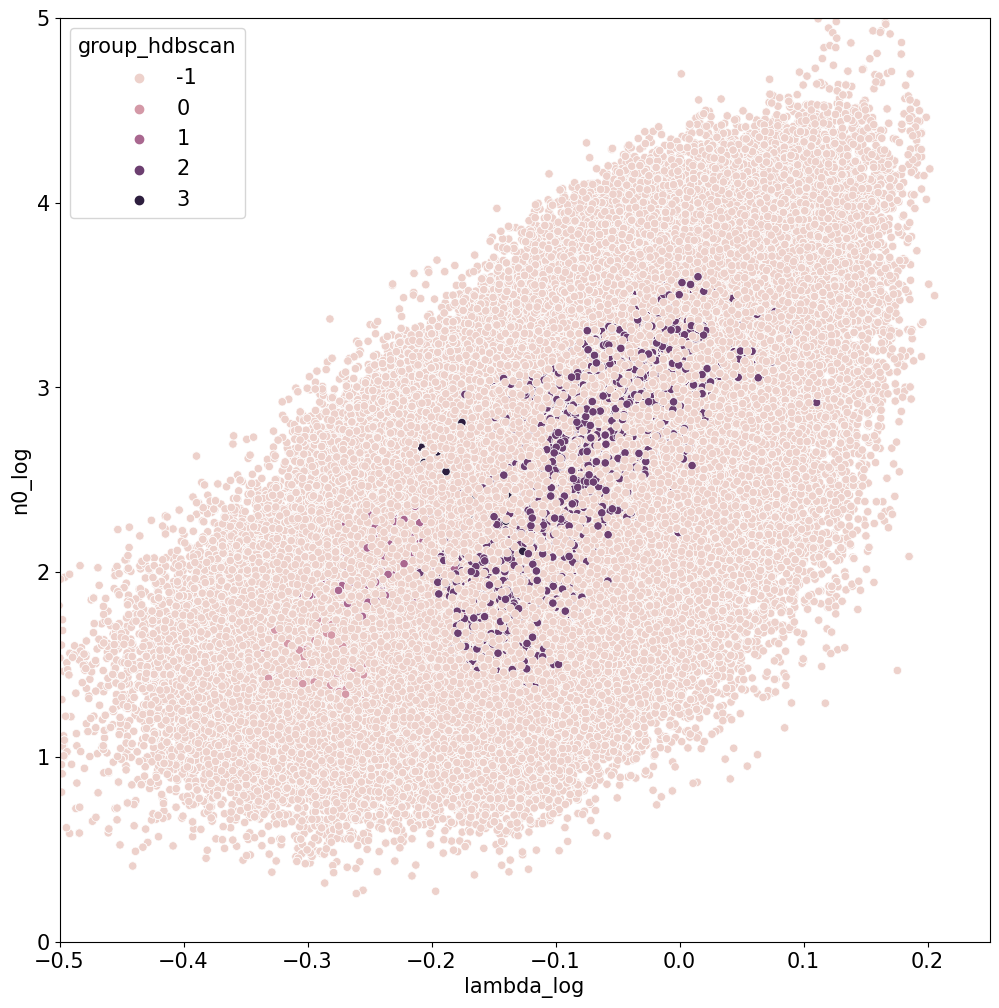

In [14]:
print(np.unique(hdb.labels_))

df_combo['group_hdbscan'] = hdb.labels_

fig, ax = plt.subplots(figsize=(12,12))
ax.set_xlim((-0.5, 0.25))
ax.set_ylim((0, 5))
sns.scatterplot(data=df_combo, x="lambda_log", y="n0_log", hue_order=[-1, 0, 1, 2], hue="group_hdbscan")
# sns.kdeplot(data=df_combo, x="lambda_log", y="n0_log", levels=2, hue="group",  hue_order=[1, 2, 3, 4, 5, 6, 7], palette=color_dict)

plt.show()